# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import math
import os
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.models import resnet50, resnet34, resnet18
import matplotlib.pyplot as plt
import IPython
from torch.optim.lr_scheduler import StepLR, ExponentialLR, MultiStepLR, ReduceLROnPlateau
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.models import convnext_tiny, convnext_small, convnext_base, convnext_large

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [3]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-10-29 13:19:18--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-10-29 13:19:18--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc921e723f66310ab1518bb644dd.dl.dropboxusercontent.com/cd/0/get/BvtD2TCeUZCqIpF5bp_JdlTAELrcprIkfw2_fb7GkhDFt40p0M-R9Edd0i1FwAnGRa8BkTrSoh-p8GJR8hNJOHim4TUr4j7qJZE5OcH3knUt4JCS6nbfVP0SKLyFExdOaFigx7V-uW9d0W-BgZ2RdxSakruS9vgibYnzU-QFs2KsgA/file?dl=1# [following]
--2022-10-29 13:19:18--  https://uc921e723f66310ab1518bb644dd.dl.dropboxusercontent.com/cd/0/get/BvtD2TCeUZCqIpF5bp_JdlTAELrcprIkfw2_fb7GkhDFt40p0M-R9Edd0i1FwAnGRa8BkTrSoh-p8GJR8

## Задание 0

### Что поможет сделать на 10 из 10 (оба задания)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [4]:
seed_everything(123456)
train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=60),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2770, 0.2691, 0.2821]) 
        ])
val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2770, 0.2691, 0.2821]) 
        ])
train_dataset = ImageFolder('/kaggle/working/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/kaggle/working/dataset/dataset/val', transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for data, _ in tqdm(loader):

        b, c, h, w = data.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(data, dim=[0, 2, 3])
        sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [ ]:
mean, std = online_mean_and_sd(train_dataloader)

In [ ]:
print(mean, std)

In [5]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

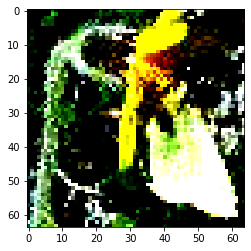

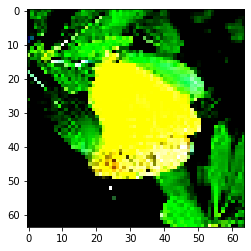

In [6]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.

### Модель (или просто импортируйте не предобученную)

### Тренировочный класс lightning

In [7]:
class MyNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model = resnet50(pretrained=False)
        self.model.fc = nn.Linear(2048, 200)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-4,
                                         weight_decay=3e-4)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": ReduceLROnPlateau(optimizer, patience=1, verbose=True, mode='max', threshold=1e-3),
            "monitor": 'accuracy',
            "frequency": 1
        },
    }
        

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)


In [8]:
seed_everything(123456)
model = MyNet()
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=40
)
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00035: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00039: reducing learning rate of group 0 to 5.0000e-07.


Validation: 0it [00:00, ?it/s]

### Валидация результатов задания

In [9]:
def evaluate_task(model, test_dataloader, device="cuda"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = model(images)
            pred_classes = torch.argmax(preds, dim=-1).long().to(device)
            accuracy_ = Accuracy().to(device)
            acc_batch = accuracy_(pred_classes, labels)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [10]:
acc = evaluate_task(model, val_dataloader).cpu()
print(acc)
print(f"Оценка за это задание составит {np.clip(10 * acc / 0.44, 0, 10):.2f} баллов")

100%|██████████| 79/79 [00:08<00:00,  9.01it/s]

tensor(0.4959)
Оценка за это задание составит 10.00 баллов


## Задание 2

Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

### Модель (или просто импортируйте предобученную)

In [4]:
seed_everything(123456)
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2770, 0.2691, 0.2821]),
        ])
train_dataset_2 = ImageFolder('/kaggle/working/dataset/dataset/train', transform=transform)
val_dataset_2 = ImageFolder('/kaggle/working/dataset/dataset/val', transform=transform)
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size=32, shuffle=False)

In [5]:
class SkyNet(pl.LightningModule):
    def __init__(self, device='cuda') -> None:
        super().__init__()
        
        self.model = convnext_base(pretrained=True).to(device)
        a = 0
        for param in self.model.parameters():
            a += 1
            if a < 342:
              param.requires_grad = False
        self.model.classifier=nn.Sequential(
                                          nn.LayerNorm([1024, 1, 1], eps=1e-06, elementwise_affine=True),
                                          nn.Flatten(start_dim=1, end_dim=-1),
                                          nn.Linear(in_features=1024, out_features=200, bias=True)
                                        )
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-4,
                                         weight_decay=3e-4)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": ReduceLROnPlateau(optimizer, patience=1, verbose=True, mode='max', threshold=1e-3),
            "monitor": 'accuracy',
            "frequency": 1
        },
    }
        

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

### Тренировочный класс lightning

In [6]:
device = 'cuda'
module = SkyNet()

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [7]:
seed_everything(123456)
trainer = pl.Trainer(accelerator="gpu",
    max_epochs=10)
trainer.fit(module, train_dataloader_2, val_dataloader_2)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 5.0000e-06.


### Валидация результатов задания

In [10]:
model = module# Подгрузить свою сохраненную модель сюда

accuracy_ = evaluate_task(model, val_dataloader_2).cpu()
print(accuracy_)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy_ - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 313/313 [01:28<00:00,  3.52it/s]

tensor(0.8444)
Оценка за это задание составит 10.00 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания

## Задание 1
Сразу решил взять resnet. Пробовал 18 и 34, но решил остановиться на 50, так как с 18 и 34 попросту не получалось выбить нужный скор. Впрочем, когда я с ними экспериментировал, то не делал аугментации. Далее использовал RandomHorizontalFlip, а по итогу поворот на 60 градусов дал результат выше. Ну все это в принципе было уже на 50ом резнете. lr взял, какой советовали брать для Adam, здесь: https://www.youtube.com/channel/UC3-KIvmiIaZimgXMNt7F99g. weight_decay - просто на рандом подбирал. Упомяну еще то, что функцию для нахождения среднего и стандартного отклонения взял с формуа pytorch.
## Задание 2
Пытался брать предобученные resnet'ы, но там максимум получилось выбить accuracy=0.64. Inception дал какой-то оч маленький результат. Потом просто решил посмотреть, какие архитектуры новее. Выбрал ConvNext, потому что в статье про нее(которая указана в доках pytorch) говорилось, что она проще трансформеров, а на классификации картинок дает схожий результат. Взял сначала tiny, но она не добивала до 0.84(дальше 0.82 чето было тяжко), small-версия аналогично. По итогу поигрался с разморозкой не только последнего слоя, а аугментацию полностью убрал(ну кроме номрализации). Ну это и позволило добиться нужного результата.